# Lens modeling with lenstronomy
Author: Robin \
Acknowledgement: 

In [1]:
# import of standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import h5py
from lenstronomy.Util import mask_util
from lenstronomy.Util import util
from lenstronomy.Data.coord_transforms import Coordinates
import joblib
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except ModuleNotFoundError:
    !pip install lenstronomy

### Extracting the observed image data from a .h5 file

In [2]:
with h5py.File('DESIJ1225-0725_F140W.h5', 'r') as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
# kwargs_data

### Extracting the information about Point Spread Function(PSF) from a .h5 file

In [3]:
with h5py.File('psf_F140W.h5', 'r') as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf['psf_type'] = 'PIXEL'
# kwargs_psf

# Visualizing the image

/tmp/ipykernel_5569/772600135.py:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix')


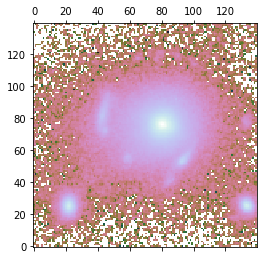

In [4]:
image_data = kwargs_data['image_data']
plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix')
# plt.grid(which='both', color='black')
# plt.minorticks_on()
# plt.grid(which='minor', color='black')
plt.show()

# Masking

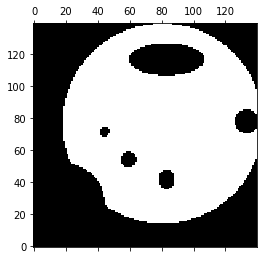

/tmp/ipykernel_5569/3164472193.py:80: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(masked_image_data),
/tmp/ipykernel_5569/3164472193.py:80: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(masked_image_data),


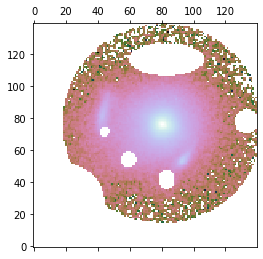

In [5]:
# To make a likelihood mask using lenstronomy functions,
# here is an example code:


ra_at_xy_0 = kwargs_data['ra_at_xy_0']
dec_at_xy_0 = kwargs_data['dec_at_xy_0']
transform_pix2angle = kwargs_data['transform_pix2angle']

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data['image_data'])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 5  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra - 0.8,
    lens_center_dec + 0.5,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords)
)


mask_ext_1 = mask_util.mask_ellipse(util.image2array(x_coords),
                                    util.image2array(y_coords),
                                    lens_center_ra - 5,
                                    lens_center_dec + 0.6,
                                    0.6, 0.6, 0)


mask_ext_2 = mask_util.mask_ellipse(util.image2array(x_coords),
                                    util.image2array(y_coords),
                                    lens_center_ra + 4.1,
                                    lens_center_dec - 3.5,
                                    2, 2, 0)


mask_ext_3 = mask_util.mask_ellipse(util.image2array(x_coords),
                                    util.image2array(y_coords),
                                    lens_center_ra - 1.,
                                    lens_center_dec - 2.3,
                                    0.4, 0.5, 0)

mask_ext_4 = mask_util.mask_ellipse(util.image2array(x_coords),
                                    util.image2array(y_coords),
                                    lens_center_ra + 0.9,
                                    lens_center_dec - 1.3,
                                    0.4, 0.4, 0)

mask_ext_5 = mask_util.mask_ellipse(util.image2array(x_coords),
                                    util.image2array(y_coords),
                                    lens_center_ra - 1,
                                    lens_center_dec + 3.7,
                                    1.9, 0.8, 0)

mask_ext_6 = mask_util.mask_ellipse(util.image2array(x_coords),
                                    util.image2array(y_coords),
                                    lens_center_ra + 2.1,
                                    lens_center_dec + 0.1,
                                    0.25, 0.25, 0)

mask = ((1 - mask_outer) * (1 - mask_ext_1) * (1 - mask_ext_2)
        * (1 - mask_ext_3) * (1 - mask_ext_4) * (1 - mask_ext_5)
        * (1 - mask_ext_6))

mask[mask >= 1] = 1
mask[mask < 0] = 0

mask = mask.reshape(num_pix, num_pix)

plt.matshow(mask, origin='lower', cmap='cubehelix')
plt.show()

# mask image data
masked_image_data = np.multiply(image_data, mask)

plt.matshow(np.log10(masked_image_data),
            origin='lower', cmap='cubehelix')
# plt.grid(which='both', color='black')
# plt.minorticks_on()
# plt.grid(which='minor', color='black')
plt.show()

## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. You can check [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{q x^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

In [6]:
lens_model_list = ['EPL', 'SHEAR']
source_model_list = ['SERSIC_ELLIPSE', 'SHAPELETS']
lens_light_model_list = ['SERSIC_ELLIPSE']

In this cell below, we have to specify the initial values, upper and lower
limits for the model parameters specific to each of the model components
specified in the above lists. The `kwargs_*_sigma` dictionaries/lists are
used to set the initial size of the search area within particle swarm
optimization (PSO) or MCMC.

### Mass model of the lens galaxy

In [7]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# EPL Profile

fixed_lens.append({})
kwargs_lens_init.append({'theta_E': 2., 'gamma': 2.5,
                         'e1': 0., 'e2': 0.,
                         'center_x': 0., 'center_y': 0.})
kwargs_lens_sigma.append({'theta_E': 0.2, 'gamma': .05,
                          'e1': 0.05, 'e2': 0.05,
                          'center_x': 0.5, 'center_y': 0.5})
kwargs_lower_lens.append({'theta_E': 1.5, 'gamma': 2.,
                          'e1': -0.5, 'e2': -0.5,
                          'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 5., 'gamma': 3.,
                          'e1': 0.5, 'e2': 0.5,
                          'center_x': 10, 'center_y': 10})
# SHEAR Profile

fixed_lens.append({'ra_0': 0., 'dec_0': 0.})
kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.,
                         'ra_0': -0.4, 'dec_0': 0.4})
kwargs_lens_sigma.append({'gamma1': 0.05, 'gamma2': 0.05,
                          'ra_0': 0.5, 'dec_0': 0.5})
kwargs_lower_lens.append({'gamma1': -0.3, 'gamma2': -0.3,
                          'ra_0': -10, 'dec_0': -10})
kwargs_upper_lens.append({'gamma1': 0.3, 'gamma2': 0.3,
                          'ra_0': 10, 'dec_0': 10})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens,
               kwargs_lower_lens, kwargs_upper_lens]

### Light model of the lens galaxy

In [8]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

# SERSIC_ELLIPSE Profile

fixed_lens_light.append({'n_sersic': 4.})
kwargs_lens_light_init.append({'R_sersic': 1., 'n_sersic': 4.,
                               'e1': 0., 'e2': 0.,
                               'center_x': 0., 'center_y': 0., 'amp': 20})
kwargs_lens_light_sigma.append({'R_sersic': 0.1, 'n_sersic': 0.5,
                                'e1': 0.05, 'e2': 0.05,
                                'center_x': 0.1, 'center_y': 0.1, 'amp': 10})
kwargs_lower_lens_light.append({'R_sersic': 0.1, 'n_sersic': 0.5,
                                'e1': -0.5, 'e2': -0.5,
                                'center_x': -10, 'center_y': -10, 'amp': 0})
kwargs_upper_lens_light.append({'R_sersic': 5, 'n_sersic': 5.,
                                'e1': 0.5, 'e2': 0.5,
                                'center_x': 10, 'center_y': 10, 'amp': 100})

joint_lens_with_light = [[0, 0, ['center_x', 'center_y', 'e1', 'e2']]]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma,
                     fixed_lens_light, kwargs_lower_lens_light,
                     kwargs_upper_lens_light]

### Light model of the source galaxy

In [9]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# SERSIC_ELLIPSE profile

fixed_source.append({'n_sersic': 1.})
kwargs_source_init.append({'R_sersic': 0.002, 'n_sersic': 1.,
                           'e1': 0., 'e2': 0.,
                           'center_x': 0., 'center_y': 0., 'amp': 16})
kwargs_source_sigma.append({'R_sersic': 0.05, 'n_sersic': 0.5,
                            'e1': 0.1, 'e2': 0.1,
                            'center_x': 0.2, 'center_y': 0.2, 'amp': 10})
kwargs_lower_source.append({'R_sersic': 0.001, 'n_sersic': 0.5,
                            'e1': -0.5, 'e2': -0.5,
                            'center_x': -10, 'center_y': -10, 'amp': 0})
kwargs_upper_source.append({'R_sersic': 0.3, 'n_sersic': 5.,
                            'e1': 0.5, 'e2': 0.5,
                            'center_x': 10, 'center_y': 10, 'amp': 100})

# SHAPELETS profile

fixed_source.append({'n_max': 11})
kwargs_source_init.append({'beta': 0.001,
                           'center_x': 0., 'center_y': 0.})
kwargs_source_sigma.append({'beta': 0.1,
                            'center_x': 0.2, 'center_y': 0.2})
kwargs_lower_source.append({'beta': 0.001,
                            'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'beta': 1.5,
                            'center_x': 10, 'center_y': 10})

joint_source_with_source = [[0, 1, ['center_x', 'center_y']]]
source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source,
                 kwargs_lower_source, kwargs_upper_source]

In [10]:
# Combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                 'lens_light_model': lens_light_params}

kwargs_constraints = {'joint_lens_with_light': joint_lens_with_light,
                      'joint_source_with_source': joint_source_with_source}

#### Numerical settings

In [11]:
kwargs_likelihood = {'check_bounds': True,
                     'image_likelihood_mask_list': [mask]}

kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False
                   }

#### Combining all the information to be sent to lenstronomy

In [12]:
kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'single-band'
                     }

## Here the model fiting is done

In [13]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model,
                              kwargs_constraints, kwargs_likelihood,
                              kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 50,
                                'n_iterations': 50}]
                       ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-1.538917379199891 reduced X^2 of best position
-8279.375500095413 log likelihood
10760 effective number of data points
[{'theta_E': 1.5068357591208796, 'gamma': 2.585421259402, 'e1': 0.03983149520862413, 'e2': 0.021127568461349836, 'center_x': -0.805964519753257, 'center_y': 0.4534425379008124}, {'gamma1': 0.09261272672706175, 'gamma2': 0.0975505319085942, 'ra_0': 0.0, 'dec_0': 0.0}] lens result
[{'amp': 1, 'R_sersic': 0.023126680715153648, 'n_sersic': 1.0, 'e1': -0.43027747433506514, 'e2': -0.34066418049425495, 'center_x': -0.2016402394301129, 'center_y': 0.2148367221251587}, {'amp': 1, 'n_max': 11, 'beta': 0.3444339253496162, 'center_x': -0.2016402394301129, 'center_y': 0.2148367221251587}] source result
[{'amp': 1, 'R_sersic': 1.25098036304291, 'n_sersic': 4.0, 'e1': 0.03983149520862413, 'e2': 0.021127568461349836, 'center_x': -0.805964519753257, 'center_y': 0.4534425379008124}] lens light result
[] point source 

## Visualizing the fitted model

-1.5254491915614719 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.5254491915614705


/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


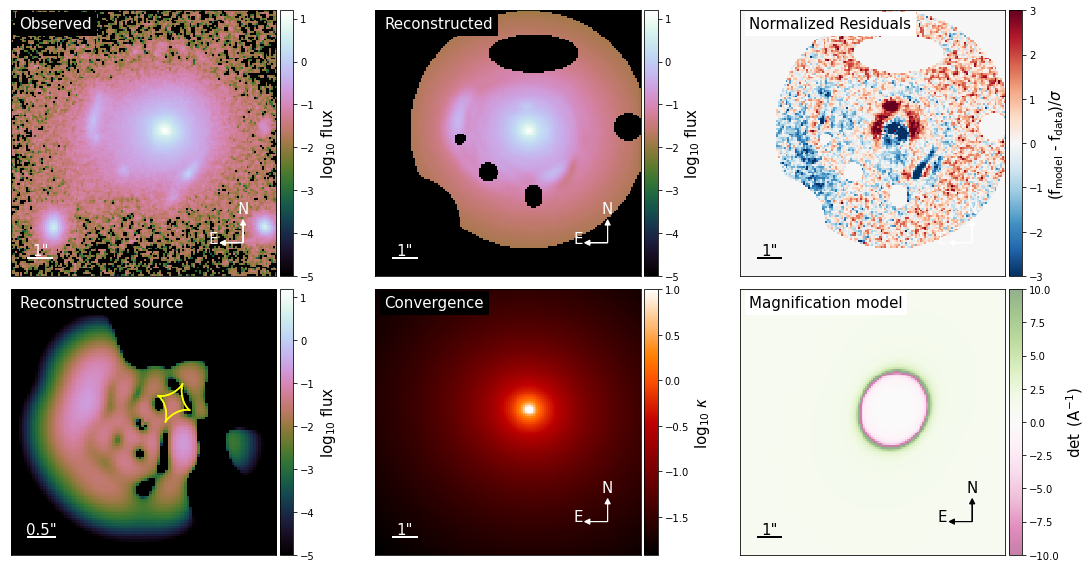

/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:506: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,
/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:506: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


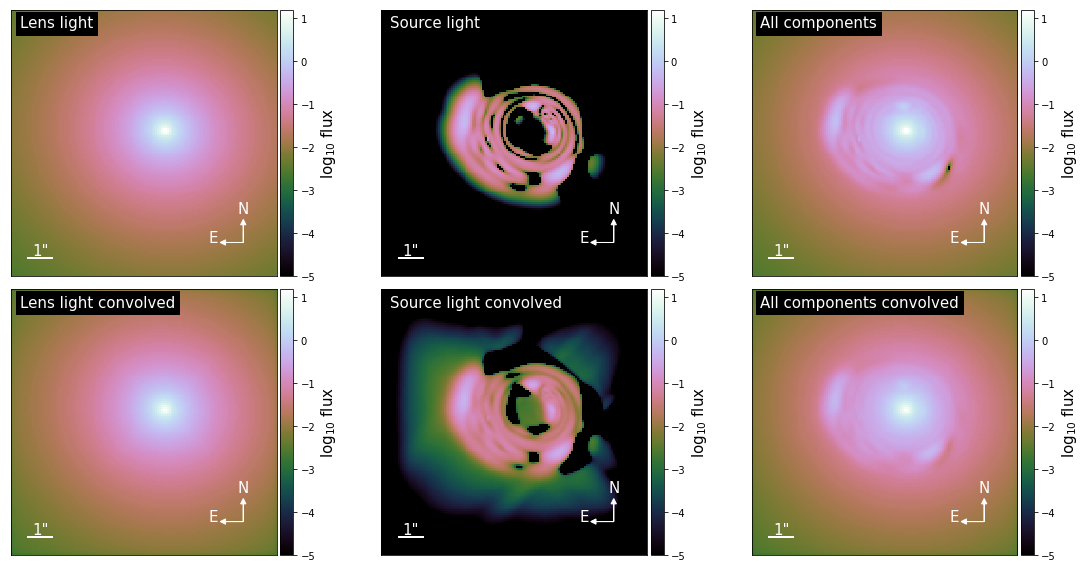

{'kwargs_lens': [{'theta_E': 1.5068357591208796, 'gamma': 2.585421259402, 'e1': 0.03983149520862413, 'e2': 0.021127568461349836, 'center_x': -0.805964519753257, 'center_y': 0.4534425379008124}, {'gamma1': 0.09261272672706175, 'gamma2': 0.0975505319085942, 'ra_0': 0.0, 'dec_0': 0.0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.023126680715153648, 'n_sersic': 1.0, 'e1': -0.43027747433506514, 'e2': -0.34066418049425495, 'center_x': -0.2016402394301129, 'center_y': 0.2148367221251587}, {'amp': 1, 'n_max': 11, 'beta': 0.3444339253496162, 'center_x': -0.2016402394301129, 'center_y': 0.2148367221251587}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 1.25098036304291, 'n_sersic': 4.0, 'e1': 0.03983149520862413, 'e2': 0.021127568461349836, 'center_x': -0.805964519753257, 'center_y': 0.4534425379008124}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [14]:
from lenstronomy.Plots.model_plot import ModelPlot

model_plot = ModelPlot(multi_band_list, kwargs_model, kwargs_result,
                       arrow_size=0.02, cmap_string="cubehelix",
                       image_likelihood_mask_list=kwargs_likelihood[
                           'image_likelihood_mask_list']
                       )

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3,
                                    cmap='RdBu_r')
model_plot.source_plot(ax=axes[1, 0], deltaPix_source=0.05,
                       with_caustics=True, scale_size=0.5, numPix=100)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap='gist_heat')
model_plot.magnification_plot(ax=axes[1, 2], cmap='PiYG')
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None,
                  top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(ax=axes[0, 0],
                              text='Lens light', lens_light_add=True,
                              unconvolved=True)
model_plot.decomposition_plot(ax=axes[1, 0],
                              text='Lens light convolved', lens_light_add=True)
model_plot.decomposition_plot(ax=axes[0, 1],
                              text='Source light', source_add=True,
                              unconvolved=True)
model_plot.decomposition_plot(ax=axes[1, 1],
                              text='Source light convolved', source_add=True)
model_plot.decomposition_plot(ax=axes[0, 2],
                              text='All components', source_add=True,
                              lens_light_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1, 2],
                              text='All components convolved', source_add=True,
                              lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None,
                  top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

In [16]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed()

init_samples = None  # can be not `None` for MCMC

input = [fitting_kwargs_list, multi_band_list, kwargs_model, 
         kwargs_constraints,
              kwargs_likelihood, kwargs_params, init_samples]
output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = 'DESIJ1225-0725_pso_output.joblib'

with open(output_path, 'wb') as f:
    joblib.dump([input, output], f, compress=True)

output_path = "DESIJ1225-0725_pso_output.joblib"

with open(output_path, 'wb') as f:
    joblib.dump([input, output], f, compress=True)

In [ ]:
# joblib.load('DESIJ1225-0725_pso_output.joblib')